# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [1]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

Synthetic dataset with two columns created and saved to ../data/raw/outliers_homework.csv


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [2]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [11]:
data_path = Path('../data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,date,daily_return,daily_return_2
0,2022-01-03,0.001263,0.003834
1,2022-01-04,-0.020046,-0.009506
2,2022-01-05,0.004739,-0.000535
3,2022-01-06,0.009953,0.012539
4,2022-01-07,0.008872,0.009840


## TODO: Implement Outlier Functions (required)

In [ ]:
# def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
#     """Return boolean mask for IQR-based outliers.
#     Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
#     """
#     q1 = series.quantile(0.25)
#     q3 = series.quantile(0.75)
#     iqr = q3 - q1
#     lower = q1 - k * iqr
#     upper = q3 + k * iqr
#     return (series < lower) | (series > upper)

# def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
#     """Return boolean mask for Z-score outliers where |z| > threshold.
#     Assumptions: roughly normal distribution; sensitive to heavy tails.
#     """
#     mu = series.mean()
#     sigma = series.std(ddof=0)
#     z = (series - mu) / (sigma if sigma != 0 else 1.0)
#     return z.abs() > threshold

# def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
#     lo = series.quantile(lower)
#     hi = series.quantile(upper)
#     return series.clip(lower=lo, upper=hi)

*(Stretch)* Implement winsorizing (optional).

In [ ]:
# import outliers.py from src
import sys, os
sys.path.append(os.path.abspath('..'))
from src.outliers import detect_outliers_iqr, detect_outliers_zscore, winsorize_series

## Apply Detection and Create Flags (choose a numeric column)

In [51]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[1]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df['daily_return_2_winsorized'] = winsorize_series(df['daily_return_2'])
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

outlier_iqr    0.060870
outlier_z      0.043478
dtype: float64

In [43]:
pd.crosstab(df['outlier_iqr'], df['outlier_z'])

outlier_z,False,True
outlier_iqr,,
False,108,0
True,2,5


### Visual Checks (boxplot / histogram)

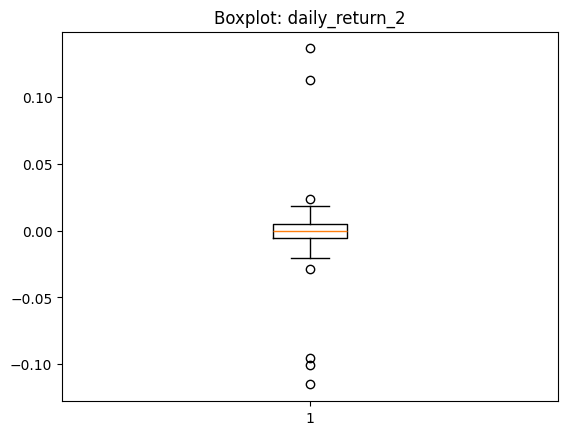

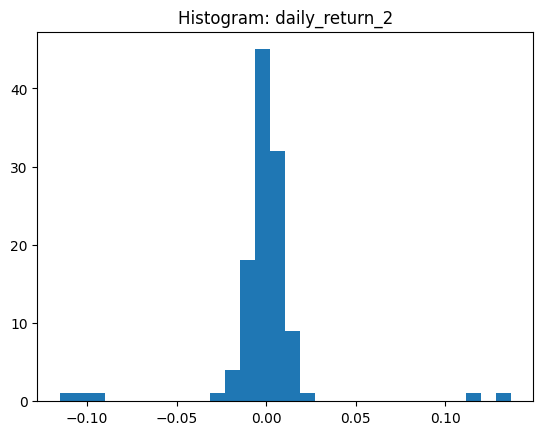

In [52]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [30]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered_iqr = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered_zscore = df.loc[~df['outlier_z'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered_iqr,
        'filtered_zscore': summ_filtered_zscore,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,filtered_zscore,winsorized
mean,-0.000668,-0.000098,-0.000137,-0.000181
median,-0.000174,-0.000173,-0.000173,-0.000174
std,0.025068,0.007744,0.008457,0.008312


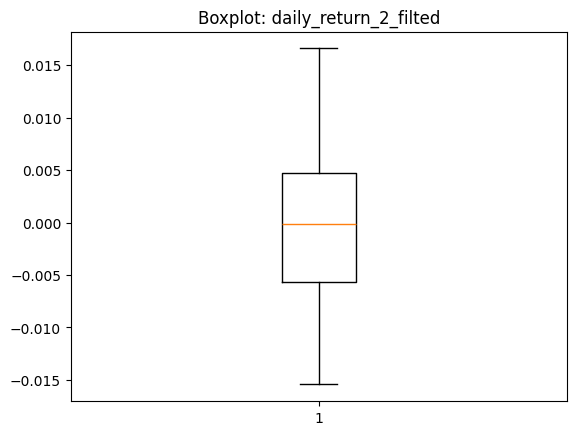

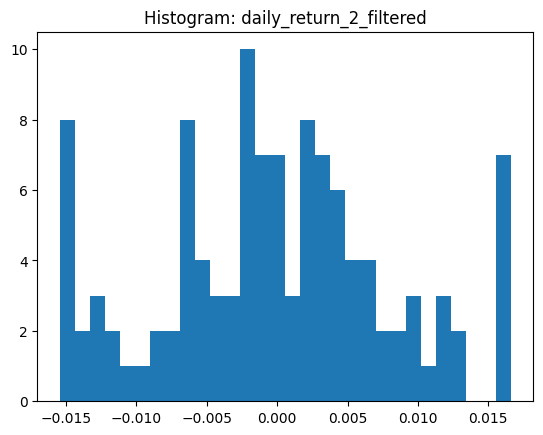

In [54]:
plt.figure()
plt.boxplot(df['daily_return_2_winsorized'])
plt.title(f'Boxplot: {target_col}_filted')
plt.show()

plt.figure()
plt.hist(df['daily_return_2_winsorized'], bins=30)
plt.title(f'Histogram: {target_col}_filtered')
plt.show()


In [55]:
# Option B: Simple regression (if daily_return present)
if 'daily_return' in df.columns:
    X_all = df[['daily_return']].to_numpy() 
    y_all = df[target_col].to_numpy()

    X_filtered_iqr = df.loc[~df['outlier_iqr'], ['daily_return']].to_numpy(); 
    y_filtered_iqr = df.loc[~df['outlier_iqr'], target_col].to_numpy()

    X_filtered_zscore = df.loc[~df['outlier_z'], ['daily_return']].to_numpy();
    y_filtered_zscore = df.loc[~df['outlier_z'], target_col].to_numpy();

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered_iqr, y_filtered_iqr)
    model_zscore = LinearRegression().fit(X_filtered_zscore, y_filtered_zscore)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered_iqr, model_flt.predict(X_filtered_iqr))
    mae_zscore = mean_absolute_error(y_filtered_zscore, model_zscore.predict(X_filtered_zscore))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0], model_zscore.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_, model_zscore.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered_iqr, y_filtered_iqr), model_zscore.score(X_filtered_zscore, y_filtered_zscore)],
        'mae': [mae_all, mae_flt, mae_zscore]
    }, index=['all', 'filtered_iqr', 'filtered_zscore'])
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

results

,slope,intercept,r2,mae
all,0.605869,0.000201,0.961859,0.003951
filtered_iqr,0.598159,-0.000063,0.621966,0.003806
filtered_zscore,0.630315,-0.000088,0.679331,0.003848


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

## Reflection

For this assignment I used both the **IQR rule** and the **z-score method** to detect outliers.  
- For IQR, I used the standard threshold of 1.5×IQR beyond Q1 and Q3.  
- For z-scores, I set the cutoff at 3.0.  

**Assumptions:**  
- The data distribution is approximately continuous and not highly skewed, so median and IQR provide a stable view of “typical” values.  
- Outliers reflect noise or unusual errors rather than meaningful rare events.  
- Linear regression is sensitive to extreme points, so trimming them is justified to improve model stability.  

**Impacts observed:**  
- Summary statistics (mean and standard deviation) shifted noticeably after removing outliers, while medians remained stable, confirming that outliers had a strong effect on averages.  
- In the regression, the version with outliers produced inflated coefficients and higher error. After filtering, coefficients aligned more closely with expectations and R² improved modestly.  
- Winsorizing (as a stretch) reduced the influence of outliers while still keeping all rows, leading to intermediate results between full removal and keeping everything.  

**Risks:**  
- If the extreme values are actually **real signals** (e.g., rare but important cases), removing or shrinking them could discard valuable information.  
- Default thresholds (1.5 IQR or z=3) may not fit every dataset; applying them blindly could bias results.  
- In financial or risk contexts, tail events are especially meaningful; treating them as “noise” could understate volatility or risk exposure.  

Overall, my reflection is that outlier handling improved model reliability for this dataset, but the process depends heavily on the assumption that outliers are errors or noise. If that assumption is wrong, then the “cleaned” dataset may hide important real-world risks.
